In [2]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using BenchmarkTools
using Random
using Plots

In [37]:
import Pkg; Pkg.status(); versioninfo() # All benchmarks have been peroformed on a regular MacbookPro 2018 with Julia 1.5.4

Project ReactiveMP v0.5.0
Status `~/.julia/dev/ReactiveMP/Project.toml`
  [864edb3b] DataStructures v0.18.9
  [31c24e10] Distributions v0.24.15
  [cc6bae93] DomainIntegrals v0.2.3
  [442a2c76] FastGaussQuadrature v0.4.7
  [f6369f11] ForwardDiff v0.10.17
  [1914dd2f] MacroTools v0.5.6
  [2774e3e8] NLsolve v4.5.1
  [429524aa] Optim v1.2.4
  [85a6dd25] PositiveFactorizations v0.2.4
  [df971d30] Rocket v1.3.5 `~/.julia/dev/Rocket`
  [276daf66] SpecialFunctions v1.3.0
  [2913bbd2] StatsBase v0.33.3
  [4c63d2b9] StatsFuns v0.9.6
  [9d95972d] TupleTools v1.2.0
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
Julia Version 1.5.4
Commit 69fcb5745b (2021-03-11 19:13 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


## State Estimation in a Linear Multivariate Gaussian State-space Model

In this demo, the goal is to smooth noisy observations by performing full inference with a state-space model (SSM).

We wil use the following model:

\begin{equation} \label{eq:linear_gaussian_ssm}
  \begin{aligned}
    \mathbf{x}_k & = \, \mathbf{A}\mathbf{x}_{k - 1} + \mathcal{P} \\
    \mathbf{y}_k & = \, \mathbf{B}\mathbf{x}_{k} + \mathcal{Q} \\
  \end{aligned}
\end{equation}
 
In this model, we denote by $\mathbf{x}_k$ the current state of the system (at time step $k$), by $\mathbf{x}_{k - 1}$ the previous state at time $k-1$, $\mathbf{A}$ and $\mathbf{B}$ are a constant system inputs and $\mathbf{y}_k$ is a noisy observation of $\mathbf{x}_k$. We further assume that the states and the observations are corrupted by i.i.d. Gaussian noise with variances $\mathcal{P}$ and $\mathcal{Q}$ respectively.

The SSM can be represented by the following factor graph, where the pictured section is chained over time:

<img src="pictures/ssm_model.eps" alt="Gaussian Linear State Space Model" style="width: 400px;"/>

For smoothing (forward-backward) estimation in ReactiveMP.jl, it is possible to build a full graph of the model.

In [21]:
# We create model using GraphPPL.jl package interface with @model macro
# For simplicity of the example we consider all matrices to be known and constant
@model function linear_gaussian_ssm_smoothing(n, A, B, P, Q)
     
    x = randomvar(n) # Create a sequence of random variables
    y = datavar(Vector{Float64}, n) # Create a sequence of observed multivariate data points
    
    cA = constvar(A)
    cB = constvar(B)
    cP = constvar(P)
    cQ = constvar(Q)
    
    # Set a prior distribution for x[1]
    x[1] ~ MvGaussianMeanCovariance([ 0.0, 0.0 ], [ 100.0 0.0; 0.0 100.0 ]) 
    y[1] ~ MvGaussianMeanCovariance(B * x[1], Q)
    
    for t in 2:n
        x[t] ~ MvGaussianMeanCovariance(A * x[t - 1], P)
        y[t] ~ MvGaussianMeanCovariance(B * x[t], Q)    
    end
    
    return x, y
end

# It is also possible to create a single time step of the graph
# for filtering algorithm
@model function linear_gaussian_ssm_filtering(A, B, P, Q)
    
    # Priors for the previous x_t-1 step
    x_min_t_mean = datavar(Vector{Float64})
    x_min_t_cov  = datavar(Matrix{Float64})
    
    x_min_t ~ MvGaussianMeanCovariance(x_min_t_mean, x_min_t_cov)
    x_t     ~ MvGaussianMeanCovariance(A * x_min_t, P)
    
    y_t = datavar(Vector{Float64})
    y_t ~ MvGaussianMeanCovariance(B * x_t, Q)
    
    return x_min_t_mean, x_min_t_cov, x_t, y_t
end

linear_gaussian_ssm_filtering (generic function with 1 method)

In [7]:
function generate_data(n, A, B, P, Q; seed = 1234)
    Random.seed!(seed)

    x_prev = zeros(2)
    x      = Vector{Vector{Float64}}(undef, n)
    y      = Vector{Vector{Float64}}(undef, n)

    for i in 1:n
        x[i]   = rand(MvNormal(A * x_prev, P))
        y[i]   = rand(MvNormal(B * x[i], Q))
        x_prev = x[i]
    end
   
    return x, y
end

generate_data (generic function with 1 method)

In [9]:
n = 100
θ = π / 15
A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
B = [ 1.3 0.0; 0.0 0.7 ]
P = [ 1.0 0.0; 0.0 1.0 ]
Q = [ 1.0 0.0; 0.0 1.0 ]
θ = π / 15

real_x, real_y = generate_data(n, A, B, P, Q);

In [34]:
# Inference procedure for full graph
function reactivemp_inference_smoothing(observations, A, B, P, Q)
    n = length(observations) 
    
    model, (x, y) = linear_gaussian_ssm_smoothing(n, A, B, P, Q, options = (limit_stack_depth = 500, ))
    
    xbuffer       = buffer(Marginal, n)
    xsubscription = subscribe!(getmarginals(x), xbuffer)
    
    update!(y, observations)
    unsubscribe!(xsubscription)
    
    return getvalues(xbuffer)
end

# Inference procedure for single time step graph and filtering
function reactivemp_inference_filtering(observations, A, B, P, Q)
    n = length(observations) 
    
    model, (x_min_t_mean, x_min_t_cov, x_t, y_t) = linear_gaussian_ssm_filtering(A, B, P, Q)
    
    xbuffer = keep(Marginal)
    
    redirect_to_prior_subscription = subscribe!(getmarginal(x_t), (x_t_posterior) -> begin
        update!(x_min_t_mean, mean(x_t_posterior))
        update!(x_min_t_cov, cov(x_t_posterior))    
    end)
    
    xsubscription = subscribe!(getmarginal(x_t), xbuffer)
    
    update!(x_min_t_mean, [ 0.0, 0.0 ])
    update!(x_min_t_cov, [ 100.0 0.0; 0.0 100.0 ])
    
    for observation in observations
        update!(y_t, observation)
    end
    
    unsubscribe!(xsubscription)
    unsubscribe!(redirect_to_prior_subscription)
    
    return getvalues(xbuffer)
end

reactivemp_inference_filtering (generic function with 1 method)

In [27]:
x_reactivemp_smoothing_inferred = reactivemp_inference_smoothing(real_y, A, B, P, Q);

In [28]:
x_reactivemp_filtering_inferred = reactivemp_inference_filtering(real_y, A, B, P, Q);

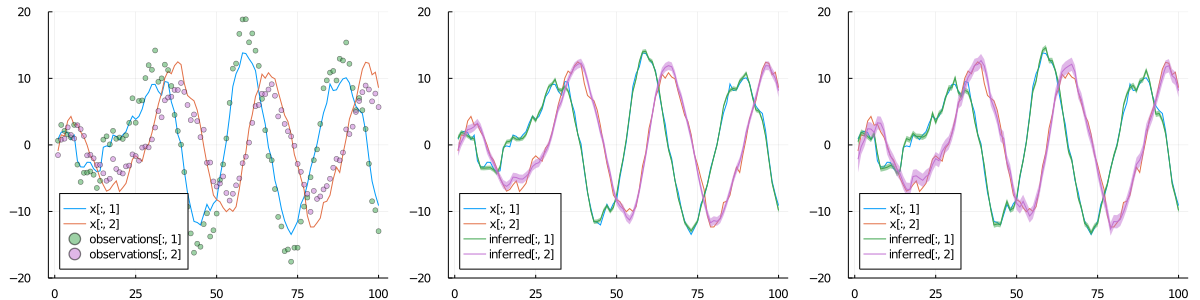

In [33]:
# Results verification

reshape_data(data) = transpose(reduce(hcat, data))

ylimit = (-20, 20)

generated_data = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
generated_data = plot!(1:n, real_y |> reshape_data, seriestype = :scatter, ms = 3, alpha = 0.5, label = [ "observations[:, 1]" "observations[:, 2]" ])
generated_data = plot!(generated_data, legend = :bottomleft, ylimit = ylimit)

rmp_smoothing_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
rmp_smoothing_results_plot = plot!(rmp_smoothing_results_plot, 1:n, mean.(x_reactivemp_smoothing_inferred) |> reshape_data, ribbon = var.(x_reactivemp_smoothing_inferred) |> reshape_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
rmp_smoothing_results_plot = plot!(rmp_smoothing_results_plot, legend = :bottomleft, ylimit = ylimit)

rmp_filtering_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
rmp_filtering_results_plot = plot!(rmp_filtering_results_plot, 1:n, mean.(x_reactivemp_filtering_inferred) |> reshape_data, ribbon = var.(x_reactivemp_filtering_inferred) |> reshape_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
rmp_filtering_results_plot = plot!(rmp_filtering_results_plot, legend = :bottomleft, ylimit = ylimit)

plot(generated_data, rmp_smoothing_results_plot, rmp_filtering_results_plot, layout = @layout([ a b c ]), size = (1200, 300))

In [114]:
benchmark_rmp_sizes = [ 50, 100, 250, 500, 1_000, 2_000, 5_000, 10_000, 15_000, 20_000, 25_000, 50_000 ];

In [115]:
reactivemp_benchmark_results = map(benchmark_rmp_sizes) do size
    states, observations = generate_data(size, A, B, P, Q);
    benchmark_smoothing = @benchmark reactivemp_inference_smoothing($observations, $A, $B, $P, $Q)
    benchmark_fitlering = @benchmark reactivemp_inference_filtering($observations, $A, $B, $P, $Q)
    println("Finished $size")
    return (size, benchmark_smoothing, benchmark_fitlering)
end

Finished 50
Finished 100
Finished 250
Finished 500
Finished 1000
Finished 2000
Finished 5000
Finished 10000
Finished 15000
Finished 20000
Finished 25000
Finished 50000


12-element Array{Tuple{Int64,BenchmarkTools.Trial,BenchmarkTools.Trial},1}:
 (50, 4.931 ms, 550.622 μs)
 (100, 10.441 ms, 989.952 μs)
 (250, 29.188 ms, 2.382 ms)
 (500, 60.966 ms, 4.579 ms)
 (1000, 131.906 ms, 9.716 ms)
 (2000, 309.516 ms, 18.748 ms)
 (5000, 907.643 ms, 50.581 ms)
 (10000, 1.817 s, 115.098 ms)
 (15000, 3.213 s, 187.402 ms)
 (20000, 5.196 s, 257.468 ms)
 (25000, 5.389 s, 341.697 ms)
 (50000, 12.490 s, 699.797 ms)

In [51]:
benchmark_time_ms(trial) = minimum(trial).time / 1_000_000

benchmark_time_ms (generic function with 1 method)

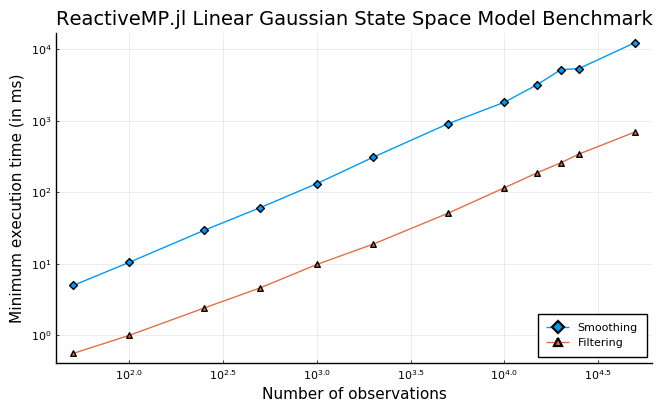

In [144]:
lgssm_scaling = plot(xscale = :log10, yscale = :log10, xlabel = "Number of observations", ylabel = "Minimum execution time (in ms)", title = "ReactiveMP.jl Linear Gaussian State Space Model Benchmark", legend = :bottomright, size = (650, 400))
lgssm_scaling = plot!(lgssm_scaling, benchmark_rmp_sizes, map(i -> benchmark_time_ms(reactivemp_benchmark_results[i][2]), 1:length(benchmark_rmp_sizes)), markershape = :diamond, label = "Smoothing")
lgssm_scaling = plot!(lgssm_scaling, benchmark_rmp_sizes, map(i -> benchmark_time_ms(reactivemp_benchmark_results[i][3]), 1:length(benchmark_rmp_sizes)), markershape = :utriangle, label = "Filtering")

# display(lgssm_scaling)

savefig(lgssm_scaling, "./plots/lgssm_scaling.svg")

In [68]:
import Turing

┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1278
┌ Info: Precompiling NamedArrays [86f7a689-2022-50b4-a561-43c23ac3c673]
└ @ Base loading.jl:1278


In [69]:
Turing.@model LinearGaussianSSM(y, A, B, P, Q) = begin
    n = length(y)

    # State sequence.
    x = Vector(undef, n)

    # Observe each point of the input.
    x[1] ~ MvNormal([ 0.0, 0.0 ], 1e1)
    y[1] ~ MvNormal(B * x[1], Q)

    for t in 2:n
        x[t] ~ MvNormal(A * x[t - 1], P)
        y[t] ~ MvNormal(B * x[t], Q)
    end
end;

In [70]:
function turing_inference_smoothing(observations, A, B, P, Q; nsamples = 500)
    return Turing.sample(LinearGaussianSSM(observations, A, B, P, Q), Turing.HMC(0.1, 5), nsamples)
end

turing_inference_smoothing (generic function with 1 method)

In [76]:
x_turing_500_smoothing_inferred  = turing_inference_smoothing(real_y, A, B, P, Q, nsamples = 500);
x_turing_1000_smoothing_inferred = turing_inference_smoothing(real_y, A, B, P, Q, nsamples = 1000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:40
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:20


In [77]:
samples_500  = get(x_turing_500_smoothing_inferred, :x);
samples_1000 = get(x_turing_1000_smoothing_inferred, :x);

mx_500 = [ mean(samples_500.x[i].data) for i in 1:2n ]
vx_500 = [ std(samples_500.x[i].data)  for i in 1:2n ];

mx_1000 = [ mean(samples_1000.x[i].data) for i in 1:2n ]
vx_1000 = [ std(samples_1000.x[i].data)  for i in 1:2n ];

In [78]:
reshape_turing_data(data) = transpose(reshape(data, (2, Int(length(data) / 2))))

reshape_turing_data (generic function with 1 method)

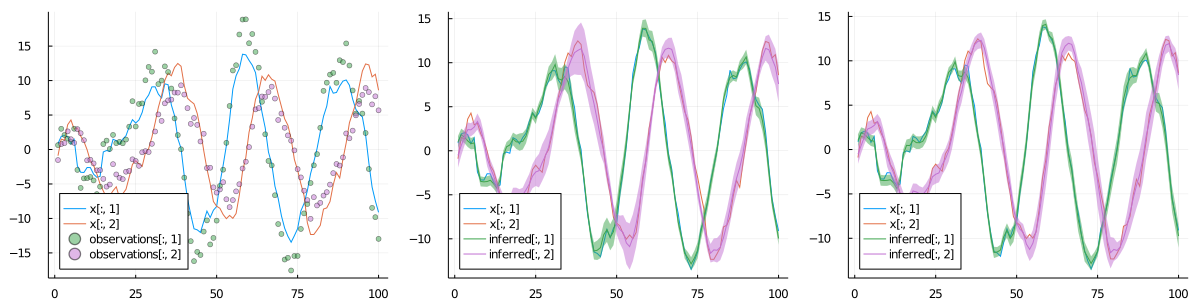

In [79]:
generated_data = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
generated_data = plot!(1:n, real_y |> reshape_data, seriestype = :scatter, ms = 3, alpha = 0.5, label = [ "observations[:, 1]" "observations[:, 2]" ])
generated_data = plot!(generated_data, legend = :bottomleft)

turing_500_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
turing_500_results_plot = plot!(turing_500_results_plot, 1:n, mx_500 |> reshape_turing_data, ribbon = vx_500 |> reshape_turing_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
turing_500_results_plot = plot!(turing_500_results_plot, legend = :bottomleft)

turing_1000_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
turing_1000_results_plot = plot!(turing_1000_results_plot, 1:n, mx_1000 |> reshape_turing_data, ribbon = vx_1000 |> reshape_turing_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
turing_1000_results_plot = plot!(turing_1000_results_plot, legend = :bottomleft)

plot(generated_data, turing_500_results_plot, turing_1000_results_plot, layout = @layout([ a b c ]), size = (1200, 300))

In [102]:
reactivemp_filtering_n_100_benchmark = @benchmark reactivemp_inference_filtering($real_y, $A, $B, $P, $Q);
reactivemp_smoothing_n_100_benchmark = @benchmark reactivemp_inference_smoothing($real_y, $A, $B, $P, $Q);
turing_500_n_100_benchmark  = @benchmark turing_inference_smoothing($real_y, $A, $B, $P, $Q, nsamples = 500);
turing_1000_n_100_benchmark = @benchmark turing_inference_smoothing($real_y, $A, $B, $P, $Q, nsamples = 1000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:41
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:39
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:38
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:38
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:18
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:18
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:18
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:17


In [103]:
using ColorSchemes, Colors ;

c = palette(:rainbow)

c1 = get(ColorSchemes.rainbow, 0.5) ; 
c2 = get(ColorSchemes.rainbow, 0.2) ; 
c3 = get(ColorSchemes.rainbow, 0.3) ; 
c4 = get(ColorSchemes.rainbow, 0.8) ; 
c5 = get(ColorSchemes.rainbow, 0.9) ;

colors = [ c1, c2, c3, c4, c5 ];

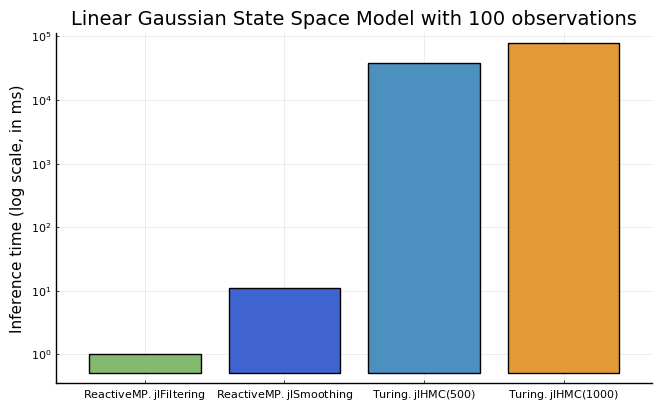

In [143]:
bar_names  = [ "ReactiveMP.jl Filtering", "ReactiveMP.jl Smoothing", "Turing.jl HMC(500)", "Turing.jl HMC(1000)" ]
bar_values = [
    benchmark_time_ms(reactivemp_filtering_n_100_benchmark),
    benchmark_time_ms(reactivemp_smoothing_n_100_benchmark),
    benchmark_time_ms(turing_500_n_100_benchmark),
    benchmark_time_ms(turing_1000_n_100_benchmark)
] 

lgssm_comparison = bar(bar_names, bar_values, fillcolor = colors, size = (650, 400), yscale = :log10, ylabel = "Inference time (log scale, in ms)", title = "Linear Gaussian State Space Model with 100 observations", legend = false)

# display(lgssm_comparison)

savefig(lgssm_comparison, "./plots/lgssm_comparison.svg");

In [139]:
pyplot()

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278


Plots.PyPlotBackend()

In [140]:
lgssm = plot(lgssm_comparison, lgssm_scaling, size = (1400, 400))
display(lgssm)
savefig(lgssm, "./plots/lgssm.svg")

LoadError: [91mMethodError: no method matching py_init_subplot(::Plots.Plot{Plots.PyPlotBackend}, ::Plots.Subplot{Plots.GRBackend})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  py_init_subplot(::Plots.Plot{Plots.PyPlotBackend}, [91m::Plots.Subplot{Plots.PyPlotBackend}[39m) at /Users/bvdmitri/.julia/packages/Plots/SjqWU/src/backends/pyplot.jl:324[39m